In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

In [2]:
# Load dataset hasil tahap 2/3
df = pd.read_csv("D:/SEMESTER 6/PROJECT CBR/data/processed/cases.csv")

# Load queries.json (5 contoh query)
with open("D:/SEMESTER 6/PROJECT CBR/data/eval/queries.json", "r", encoding="utf-8") as f:
    queries = json.load(f)

In [3]:
# Pastikan ringkasan fakta tidak NaN
df['ringkasan_fakta'] = df['ringkasan_fakta'].fillna("")
df['amar'] = df['amar'].fillna("Tidak ada amar")

# TF-IDF Vectorization untuk Similarity
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['ringkasan_fakta'])

# Ekstraksi solusi → dict {case_id: amar}
case_solutions = dict(zip(df['case_id'], df['amar']))

# Fungsi retrieve() untuk top-k case_id + similarity score
def retrieve_with_score(query: str, k: int = 5):
    query_vec = vectorizer.transform([query.lower()])
    sims = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_k_idx = sims.argsort()[-k:][::-1]
    top_k_ids = df.iloc[top_k_idx]['case_id'].tolist()
    top_k_scores = sims[top_k_idx]
    return list(zip(top_k_ids, top_k_scores))

# Fungsi Prediksi Majority Vote
def predict_outcome_majority(query: str, k: int = 5):
    top_k = retrieve_with_score(query, k)
    solutions = [case_solutions[cid] for cid, _ in top_k]
    most_common = Counter(solutions).most_common(1)[0][0]
    return most_common, [cid for cid, _ in top_k]

# Fungsi Prediksi Weighted Vote
def predict_outcome_weighted(query: str, k: int = 5):
    top_k = retrieve_with_score(query, k)
    weight_map = {}
    for cid, score in top_k:
        sol = case_solutions[cid]
        weight_map[sol] = weight_map.get(sol, 0) + score
    best_solution = max(weight_map.items(), key=lambda x: x[1])[0]
    return best_solution, [cid for cid, _ in top_k]

# Prediksi semua query uji → Simpan hasil
Path("D:/SEMESTER 6/PROJECT CBR/data/results").mkdir(parents=True, exist_ok=True)
results = []

for q in queries:
    query_id = q['query_id']
    query_text = q['query']

    pred_sol, top_k_ids = predict_outcome_majority(query_text)

    results.append({
        "query_id": query_id,
        "query_text": query_text,
        "predicted_solution": pred_sol,
        "top_5_case_ids": top_k_ids
    })

# Simpan ke CSV
results_df = pd.DataFrame(results)
results_df.to_csv("D:/SEMESTER 6/PROJECT CBR/data/results/predictions.csv", index=False)

print("File D:/SEMESTER 6/PROJECT CBR/data/results/predictions.csv berhasil dibuat.")

File D:/SEMESTER 6/PROJECT CBR/data/results/predictions.csv berhasil dibuat.


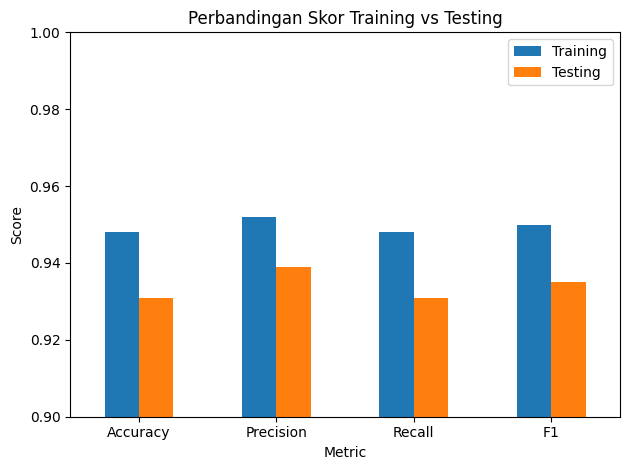

In [ ]:
metrics = pd.DataFrame({
    'Metric' : ['Accuracy','Precision','Recall','F1'],
    'Training': [0.948,0.952,0.948,0.950],
    'Testing' : [0.931,0.939,0.931,0.935]
}).set_index('Metric')

ax = metrics.plot(kind='bar', color=['steelblue', 'darkorange'])
ax.set_ylim(0.90, 1.00)
ax.set_ylabel('Score')
ax.set_xlabel('Metric')
ax.set_title('Perbandingan Skor Training vs Testing')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()